In [14]:
'''
author: Felix Hol
date: 2019 July 22
content: code to track mosquitoes, several filtering parameters will need tweaking depending on imaging parameters.
Output is:
1) a pickle containing all detected centroids per frame
2) a pickle containing centroids tracked over time (/frame)
modified by Greg Murray 2020 May 23 
'''

####
#The list of paths searched by Python on import is found in sys.path:
import sys
sys.path

# Install packages that were causing problems due to seperate Jupyter kernels and shell - more info here - https://jakevdp.github.io/blog/2017/12/05/installing-python-packages-from-jupyter/

import sys
!{sys.executable} -m pip install pims
!{sys.executable} -m pip install trackpy
!{sys.executable} -m pip install joblib

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
# %matplotlib inline
# import matplotlib as mpl
# import matplotlib.pyplot as plt
import os
import itertools as it
import pandas as pd
import pims
import skimage
from skimage import data, io, util
from skimage.measure import label, regionprops
from skimage.morphology import binary_dilation, erosion, dilation, opening, binary_closing, closing, white_tophat, remove_small_objects, disk, black_tophat, skeletonize, convex_hull_image
import scipy
import trackpy as tp
import pylab
import math
from joblib import Parallel, delayed
import multiprocessing
from datetime import datetime
from tqdm import tnrange, tqdm
import pickle
import glob
import cv2 as cv


In [15]:
#### set directories where to get images and where to store output, and specifics of experiment

dataDir = 'D:/BiteOscope_test_images/testImages/'
saveDir = 'D:/BiteOscope_test_images/test_ouput/'
species = 'alb'
mosAge = 0      #### mosquito age in days
mosDataName = 'test'
frames = pims.ImageSequence(dataDir+'/*.tiff', as_grey=True)
borderToExclude = 0     #### excludes the outer n pixels of the frame (in both x and y)
startFrame = 700
stopFrame = 750
startFrameBG = 1
stopFrameBG = len(frames)
searchRadius = 600

In [16]:
#### create background image (BG image can be updated periodically - usually not necessary)

def getBG(start, stop, step):
    numBGframes = int(np.ceil((stop - start) /step) + 1)
    frameSize = frames[1].shape
    BG = np.zeros([frameSize[0], frameSize[1], numBGframes])

    j = 1
    for i in range(start, stop, step):
        j += 1
        BG[:, :, j - 1] = np.invert(frames[i])    
    BG = np.median(BG, axis=2)
    return BG

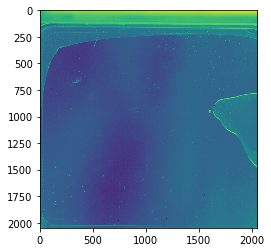

In [17]:
BG = getBG(startFrameBG, stopFrameBG, int(len(frames) / 30))
plt.imshow(BG)

In [18]:
def trackMosq2(i, borderToExclude):
    frameSize = frames[1].shape
    # borderToExclude = 0
    selem1 = disk(8)
    selem2 = disk(1)
    A = np.zeros(frameSize)
    A = A + np.invert(frames[i])
    B = A - BG
    if B.min() > 0:
        Bm = B - B.min()
    else:
        Bm = B
    Bt = Bm > 90
    Bts = remove_small_objects(Bt, min_size=400)
    Be = erosion(Bts, selem2)
    Bf = remove_small_objects(Be, min_size=300)
    Bc = binary_closing(Bf, selem1)
    C = B * Bc
    eroded = erosion(C, selem2)
    eroded = skimage.filters.gaussian(eroded, 4)
    eroded[eroded < 0] = 0
    erL = label(eroded>0)
    erR = regionprops(erL, C)#, coordinates='xy')
    l = 1
    for props in erR:   #### this filters out objects that are way too larger or small and excludes detections near the edge when desired
        if props.area > 50000:
            erL[erL==l] = 0
        if props.area < 1000:
            erL[erL==l] = 0
        if props.major_axis_length > 3000:
            erL[erL==l] = 0
        if props.centroid[0] < borderToExclude or props.centroid[1] < borderToExclude or props.centroid[0] > frameSize[0] - borderToExclude or props.centroid[1] > frameSize[1] - borderToExclude:
            erL[erL==l] = 0
        l = l +1
    erLf = label(erL>0)
    erodedF = eroded * (erLf > 0)
    erRf = regionprops(erLf, C)#, coordinates='xy')
    centroids = np.zeros([len(erRf), 2])
    numCent = 0
    for props in erRf:
        centroids[numCent] = props.centroid
        numCent += 1
    cenS= centroids.shape; numCen = cenS[0]
    frameNo = i
    frameNoCen = np.zeros((numCen,1), dtype=np.int)
    frameNoCen[:] = frameNo
    centroidsF = np.hstack((centroids,frameNoCen))
    numCents = centroidsF.shape[0]
    return centroidsF, numCents

C:\Users\Greg\Anaconda3\envs\dlc-windowsGPU\lib\site-packages\skimage\measure\_regionprops.py:250: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See http://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)
C:\Users\Greg\Anaconda3\envs\dlc-windowsGPU\lib\site-packages\skimage\measure\_regionprops.py:260: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See http://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)


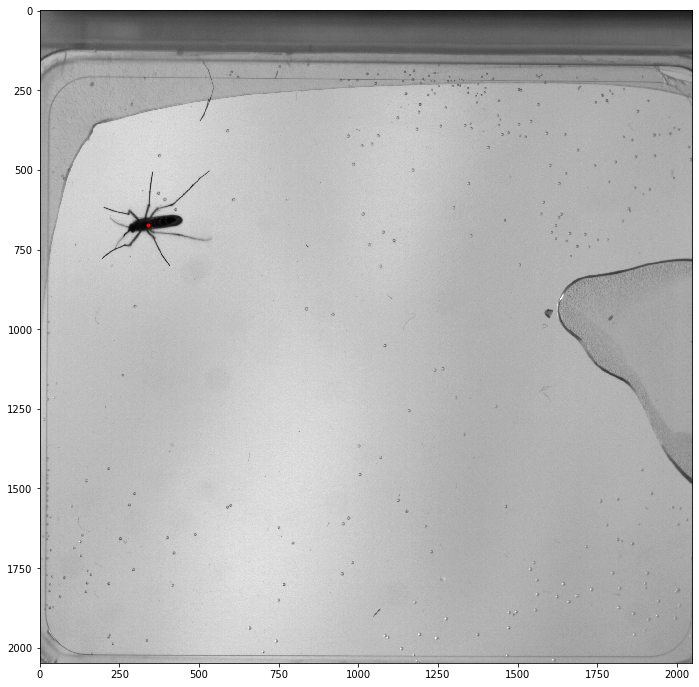

In [19]:
#####testing....
i = 501
centroidsF, numCents = trackMosq2(i, borderToExclude)
plt.figure(figsize=(18,12))
plt.imshow(frames[i], cmap = 'gray')
# plt.imshow(eroded)
# plt.plot(coordinatesF[:,1],coordinatesF[:,0],'r.')
plt.plot(centroidsF[:,1],centroidsF[:,0],'r.')

In [20]:
centroidsAllT = np.zeros((1,3))
num_cores = multiprocessing.cpu_count()

print('detecting centriods of mosquitoes in frames ' + str(startFrame) + ' - ' + str(stopFrame) + ' using ' + str(num_cores) + ' cores')

results = Parallel(n_jobs=num_cores)(delayed(trackMosq2)(i, borderToExclude) for i in tqdm(range(startFrame, stopFrame)))

centroidsAllT = np.zeros((1,3))

for i in range(len(results)):
    centroidsAllT = np.vstack((centroidsAllT,results[i][0]))

centroidPickleName = saveDir + mosDataName + '_centroids.pkl'
    
with open(centroidPickleName, 'wb') as f:
    pickle.dump(centroidsAllT, f)
    
### convert centroids to dataframe

df_cenAllT = pd.DataFrame(centroidsAllT)
df_cenAllT = df_cenAllT.rename(columns={0: "y", 1: "x", 2: "frame"})

### track (link mosquitoes across frames). Adjust search radius depending on how crowded the images are

print('linking centroids through time using search radius: ' + str(searchRadius))

tFull = tp.link_df(df_cenAllT, searchRadius, memory=3)

tFull['species'] = species
tFull['age'] = mosAge

tFull = tFull.drop([0])

trackPickleName = saveDir + mosDataName + '_tracks.pkl'
tFull.to_pickle(trackPickleName)

print('output saved at ' + saveDir)

Frame 749: 1 trajectories present.
output saved at D:/BiteOscope_test_images/test_ouput/
